# Example Covertype dataset
- In this notebook, we introduce how to use `ShapEngine` to compute Beta Shapley value. 

In [1]:
import os, sys, argparse
from time import time
import numpy as np
np.random.seed(2022)
sys.path.append('../betashap')
from ShapEngine import ShapEngine
import utils, data

# Load data 
- We use the **Covertype** dataset (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html) and suppose 10% of data points in the training dataset is mislabeled.
- A function `data.load_data` will load the train, val, and test datasets as well as a noisy index. 

In [2]:
problem='classification'
dataset='covertype'
dargs={'n_data_to_be_valued': 200, 'n_val': 200, 'n_test': 1000}

In [3]:
# Load dataset
(X, y), (X_val, y_val), (X_test, y_test), noisy_index=data.load_data(problem, dataset, **dargs)    

print('-'*30)
print(f'Train X: {X.shape}')
print(f'Val X: {X_val.shape}')
print(f'Test X: {X_test.shape}')
print('-'*30)

--------------------------------------------------
Covertype
--------------------------------------------------
number of samples: 200
------------------------------
Train X: (200, 54)
Val X: (200, 54)
Test X: (1000, 54)
------------------------------


# Compute Beta Shapley

In [4]:
model_family='logistic'
metric='accuracy'
GR_threshold=1.05
weights_list=[(1, 16), (1, 4), (1,1), (4,1), (16, 1)]

In [5]:
# Evaluate values
shap_engine=ShapEngine(X=X, y=y, X_val=X_val, y_val=y_val, 
                       problem=problem, model_family=model_family, 
                       metric=metric, GR_threshold=GR_threshold)
%time shap_engine.run(weights_list=weights_list)

Source is initialized. A unit of sample is one data point
Start: Marginal Contribution Calculation!
Total number of random sets: 1000, GR_stat: 1.0065049184406565
Done: Marginal Contribution Calculation! 
CPU times: user 4min 38s, sys: 6.64 s, total: 4min 45s
Wall time: 4min 45s


In [6]:
# A vector of data values is stored in `shap_engine.results` 
print(f'List of data values: {list(shap_engine.results.keys())}')

List of data values: ['Beta(16,1)', 'Beta(4,1)', 'Beta(1,1)', 'Beta(1,4)', 'Beta(1,16)', 'LOO-Last']


In [7]:
# Beta(4:1) data values for the first 10 data points. 
first_ten_values=shap_engine.results['Beta(4,1)'][:10]
print(f'First 10 data values: {first_ten_values}')

First 10 data values: [-0.00259993 -0.02953007  0.0015129   0.00535153  0.00819468 -0.00120866
 -0.01590109  0.000218    0.00661177  0.00437736]


In [8]:
MC_mat=shap_engine.MC_obs_card_mat/(shap_engine.MC_count_obs_card_mat+1e-16)
print(f'Shape of MC_mat : {MC_mat.shape}')
print(f'First 12 marginal contributions of the first sample:\n {np.array(MC_mat[0])[:12]}')

Shape of MC_mat : (200, 200)
First 12 marginal contributions of the first sample:
 [ 0.         -0.037      -0.0175     -0.02       -0.00875    -0.0175
 -0.0125     -0.00125    -0.015      -0.003      -0.00333333  0.012     ]


# Marginal contributions for clean and noisy samples
- Figure 2 in the manuscript shows a smooth curve because it is based on 50 independent runs.

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Marginal Contributions')

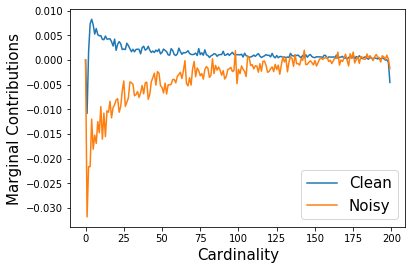

In [10]:
clean_index=[i for i in range(MC_mat.shape[0]) if i not in noisy_index]
plt.plot(np.arange(MC_mat.shape[0]), np.mean(MC_mat[clean_index], axis=0), label='Clean')
plt.plot(np.arange(MC_mat.shape[0]), np.mean(MC_mat[noisy_index], axis=0), label='Noisy')
plt.legend(fontsize=15)
plt.xlabel('Cardinality', fontsize=15)
plt.ylabel('Marginal Contributions', fontsize=15)

# Performance on downstream ML tasks

In [11]:
%time result_dict=utils.summary_experiments(shap_engine, noisy_index, X_test, y_test)
print(f'Available ML tasks: {list(result_dict.keys())}')

CPU times: user 5.12 s, sys: 116 ms, total: 5.23 s
Wall time: 5.24 s
Available ML tasks: ['noisy', 'subsampling', 'point_removal', 'point_addition']


In [12]:
# For instance, a noisy label detection task result is stored in result_dict['noisy'] 
print('For each method, the following dictionary shows recall, precision, and F1-score.')
result_dict['noisy'] 

For each method, the following dictionary shows recall, precision, and F1-score.


{'Beta(16,1)': [0.35, 0.3888888888888889, 0.3684210526315789],
 'Beta(4,1)': [0.45, 0.45, 0.44999999999999996],
 'Beta(1,1)': [0.5, 0.35714285714285715, 0.4166666666666667],
 'Beta(1,4)': [0.35, 0.14285714285714285, 0.20289855072463767],
 'Beta(1,16)': [0.3, 0.11764705882352941, 0.16901408450704225],
 'LOO-Last': [0.15, 0.0625, 0.08823529411764705]}